## Analysis Features

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum, avg, count, month, countDistinct

In [0]:
spark = SparkSession.builder.appName("Analysis Features").getOrCreate()

In [0]:
df = spark.read.csv("dbfs:/FileStore/Retail_Store_Chain_Analysis/4_final_data.csv", 
                     header=True, inferSchema=True)

In [0]:
# # Convert Spark DataFrame to Pandas DataFrame for visualization
# def to_pandas(df):
#     return df.toPandas()

- Product performance metrics 

In [0]:
# Calculate product performance metrics
product_performance = df.groupBy("Product ID", "Product Name","Category").agg(
    sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales"),
    count("Order ID").alias("Total Orders")
)
top_20_products = product_performance.orderBy("Total Sales", ascending=False).limit(20)
top_20_products.show(truncate=False)


+---------------+-------------------------------------------------------------------------------+---------------+------------------+------------------+------------+
|Product ID     |Product Name                                                                   |Category       |Total Sales       |Average Sales     |Total Orders|
+---------------+-------------------------------------------------------------------------------+---------------+------------------+------------------+------------+
|FUR-CH-10004287|SAFCO Arco Folding Chair                                                       |Furniture      |6055.969999999998 |465.843846153846  |13          |
|OFF-ST-10003716|Tennsco Double-Tier Lockers                                                    |Office Supplies|5636.465999999999 |469.7055          |12          |
|FUR-TA-10003473|Bretford Rectangular Conference Table Tops                                     |Furniture      |5608.217999999999 |467.35149999999993|12          |
|FUR-CH-10

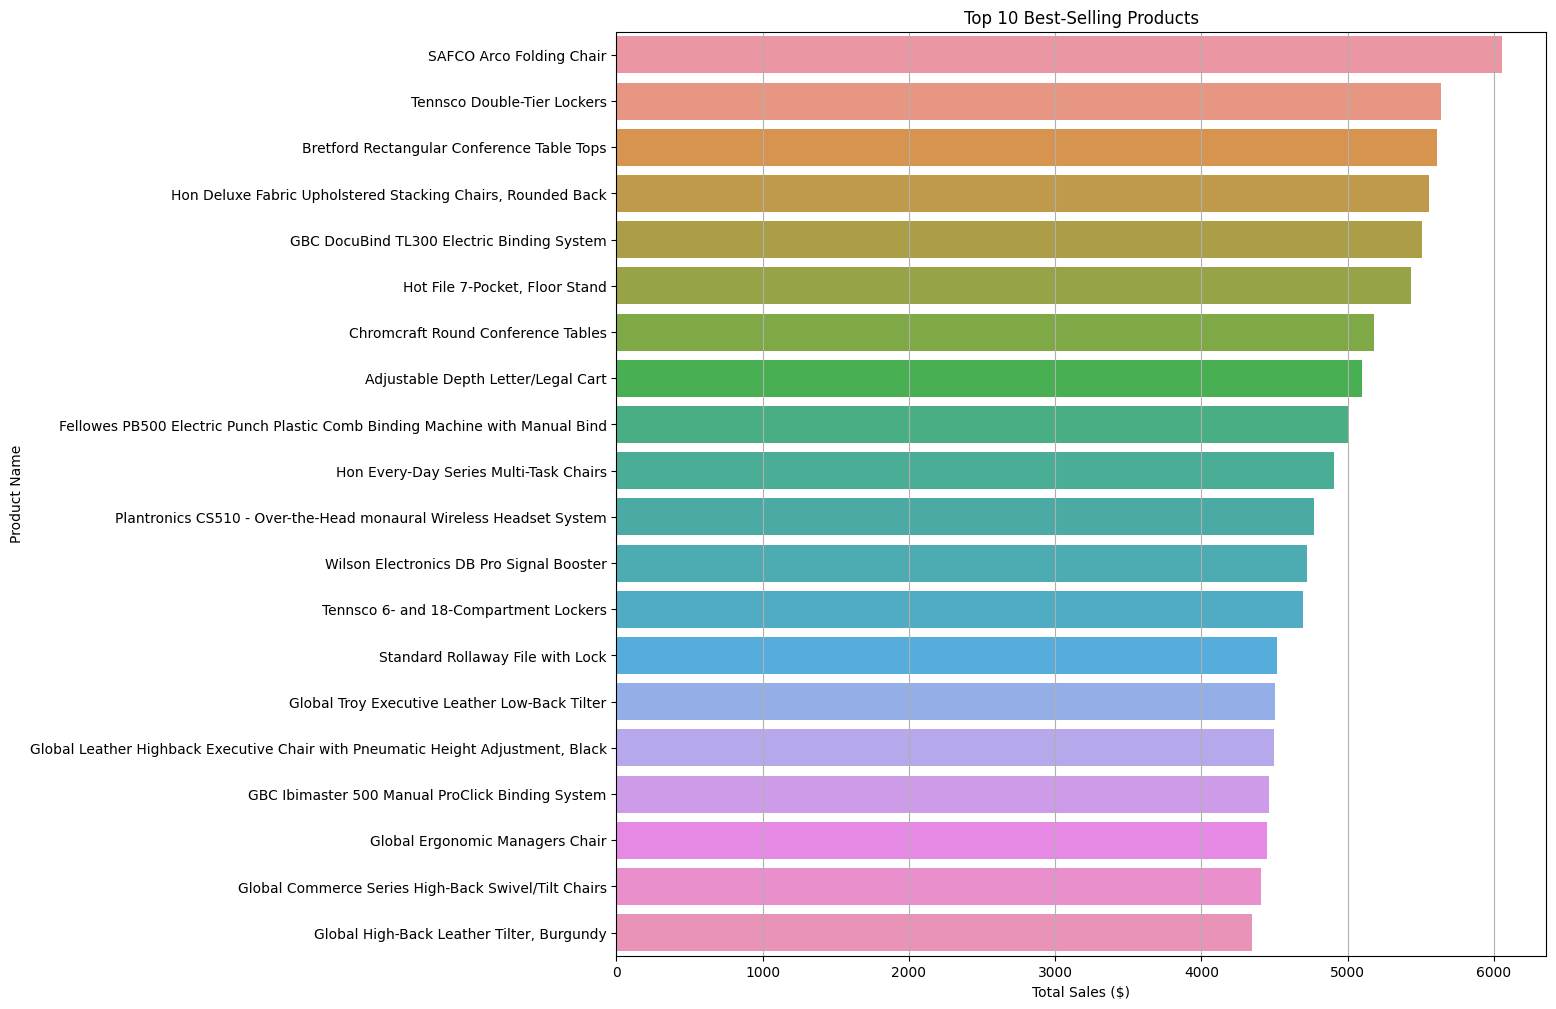

In [0]:


product_performance_pd = product_performance.toPandas()
# Sort data 
product_performance_pd = product_performance_pd.sort_values(by="Total Sales", ascending=False).head(20)

# plot
plt.figure(figsize=(12, 12))
sns.barplot(
    x="Total Sales", 
    y="Product Name", 
    data=product_performance_pd
)
plt.xlabel("Total Sales ($)")
plt.ylabel("Product Name")
plt.title("Top 10 Best-Selling Products")
plt.grid(axis="x")
plt.show()


- Regional sales comparison 

In [0]:
# Calculate total sales and average sales by region
regional_sales_comparison = df.groupBy("Region").agg(
    sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales")
).orderBy("Total Sales", ascending=False)
regional_sales_comparison.show(truncate=False)


+-------+------------------+------------------+
|Region |Total Sales       |Average Sales     |
+-------+------------------+------------------+
|West   |453913.02400000347|144.55828789809027|
|East   |393061.5650000013 |141.13521184919256|
|Central|306869.5690000008 |134.76924418094018|
|South  |226151.16000000082|141.52137672090163|
+-------+------------------+------------------+



- **West** leads in total sales and has the highest average sales per transaction.  
- **East** follows with strong sales and a similar average sales value.  
- **Central** has lower average sales but solid total sales.  
- **South** has the lowest total sales but competitive average sales.

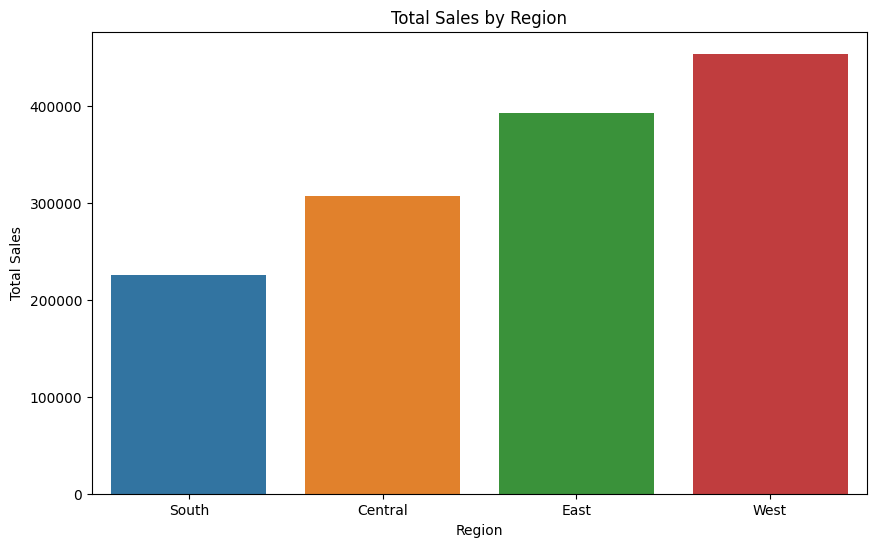

In [0]:

regional_sales_comparison_pd = regional_sales_comparison.toPandas()
# Bar plot for Total Sales by Region
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Total Sales', data=regional_sales_comparison_pd)
plt.title('Total Sales by Region')
plt.xlabel('Region')
plt.ylabel('Total Sales')
plt.show()


- Seasonal trend analysis 

In [0]:
seasonal_trends = df.select(
    "Order Date", "Sales"
).withColumn(
    "Month", month("Order Date")
).groupBy("Month").agg(
    sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales")
).orderBy("Month")

seasonal_trends.show(truncate=False)

+-----+------------------+------------------+
|Month|Total Sales       |Average Sales     |
+-----+------------------+------------------+
|1    |51303.44300000006 |140.1733415300548 |
|2    |40085.759         |134.9688855218855 |
|3    |100067.41700000006|147.15796617647067|
|4    |86569.25699999997 |131.76447031963465|
|5    |96129.8240000002  |132.59286068965545|
|6    |98081.91700000013 |141.94199276411018|
|7    |100378.04300000017|144.01440889526566|
|8    |99772.71100000017 |143.97216594516618|
|9    |182002.83700000044|134.41863884785852|
|10   |109063.1270000002 |134.8122707045738 |
|11   |214841.16900000043|148.26857763975184|
|12   |201699.81400000048|145.94776700434187|
+-----+------------------+------------------+



- Sales are highest in **November and December**.  
- **March and November** have the highest average sales per transaction.  
- **February has the lowest total sales**. 

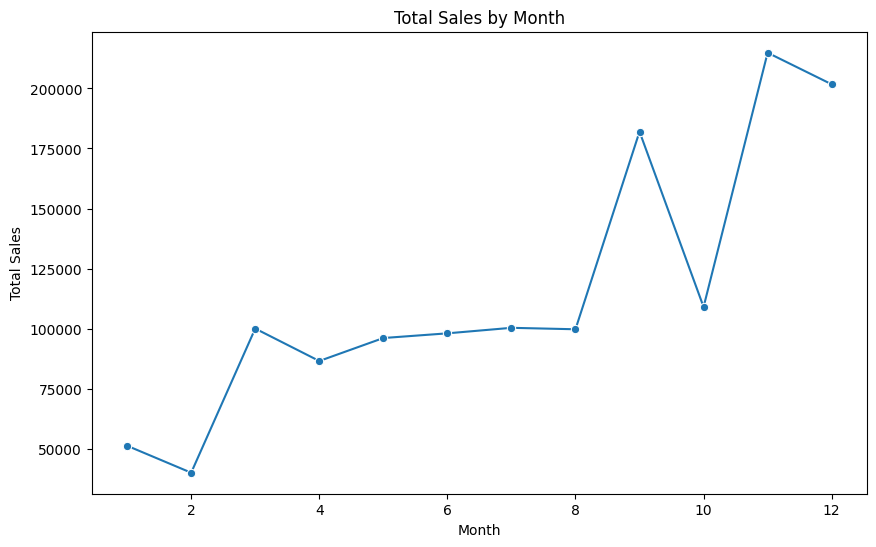

In [0]:
# Convert Spark DataFrame to Pandas DataFrame for visualization
seasonal_trends_pd = seasonal_trends.toPandas()

# Line plot for Total Sales by Month
plt.figure(figsize=(10, 6))
sns.lineplot(x='Month', y='Total Sales', data=seasonal_trends_pd, marker='o')
plt.title('Total Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()


- Customer segment profitability 

In [0]:
# Calculate total sales and average sales by customer segment
customer_segment_profitability = df.groupBy("Segment").agg(
    sum("Sales").alias("Total Sales"),
    avg("Sales").alias("Average Sales")
).orderBy("Total Sales", ascending=False)
customer_segment_profitability.show(truncate=False)


+-----------+------------------+------------------+
|Segment    |Total Sales       |Average Sales     |
+-----------+------------------+------------------+
|Consumer   |710518.7799999923 |139.29009605959465|
|Corporate  |422154.8120000022 |142.9579451405358 |
|Home Office|247321.72600000032|141.65047308132893|
+-----------+------------------+------------------+



- **Consumers** bring in the highest sales.  
- **Corporate** has the highest average sales per transaction.  
- **Home Office** has the lowest total sales but a similar average sales value as other segments.  


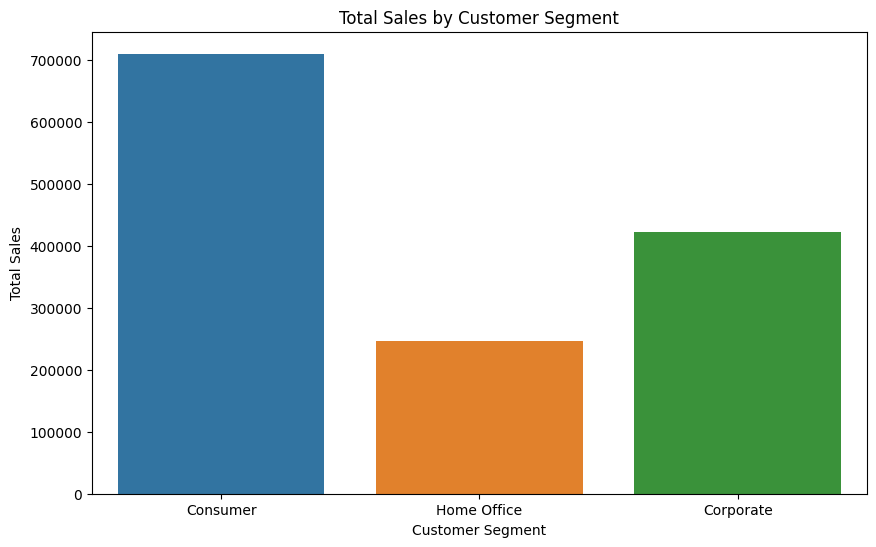

In [0]:
customer_segment_profitability_pd = customer_segment_profitability.toPandas()

# Bar plot for Total Sales by Customer Segment
plt.figure(figsize=(10, 6))
sns.barplot(x='Segment', y='Total Sales', data=customer_segment_profitability_pd)
plt.title('Total Sales by Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.show()


- Build KPI summary tables

In [0]:


# Calculate KPIs
total_sales = df.agg(sum("Sales").alias("Total Sales")).collect()[0]["Total Sales"]
total_orders = df.agg(count("Order ID").alias("Total Orders")).collect()[0]["Total Orders"]
average_order_value = df.agg((sum("Sales") / count("Order ID")).alias("Average Order Value")).collect()[0]["Average Order Value"]
total_customers = df.agg(countDistinct("Customer ID").alias("Total Customers")).collect()[0]["Total Customers"]
total_products_sold = df.agg(count("Product ID").alias("Total Products Sold")).collect()[0]["Total Products Sold"]
average_sales_per_customer = df.groupBy("Customer ID").agg(sum("Sales").alias("Total Sales")).agg(avg("Total Sales").alias("Average Sales per Customer")).collect()[0]["Average Sales per Customer"]
average_sales_per_product = df.groupBy("Product ID").agg(sum("Sales").alias("Total Sales")).agg(avg("Total Sales").alias("Average Sales per Product")).collect()[0]["Average Sales per Product"]

# Ensure all values are of the same type (float)
total_sales = float(total_sales)
total_orders = float(total_orders)
average_order_value = float(average_order_value)
total_customers = float(total_customers)
total_products_sold = float(total_products_sold)
average_sales_per_customer = float(average_sales_per_customer)
average_sales_per_product = float(average_sales_per_product)

# Create a KPI summary table
kpi_summary = spark.createDataFrame([
    ("Total Sales", total_sales),
    ("Total Orders", total_orders),
    ("Average Order Value", average_order_value),
    ("Total Customers", total_customers),
    ("Total Products Sold", total_products_sold),
    ("Average Sales per Customer", average_sales_per_customer),
    ("Average Sales per Product", average_sales_per_product)
], ["KPI", "Value"])

kpi_summary.show(truncate=False)


+--------------------------+------------------+
|KPI                       |Value             |
+--------------------------+------------------+
|Total Sales               |1379995.3179999753|
|Total Orders              |9800.0            |
|Average Order Value       |140.81584877550767|
|Total Customers           |793.0             |
|Total Products Sold       |9800.0            |
|Average Sales per Customer|1740.2210819672116|
|Average Sales per Product |741.534292315959  |
+--------------------------+------------------+




This table gives a quick view of business performance.  